In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
img_size = 120
#batch = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/dataset/train",
    #shuffle = True,
    #batch_size = batch,
    image_size = (img_size, img_size)
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/dataset/test",
    #shuffle = True,
    #batch_size = batch,
    image_size = (img_size, img_size)
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/dataset/validation",
    #shuffle = True,
    #batch_size = batch,
    image_size = (img_size, img_size)
)

Found 350 files belonging to 5 classes.
Found 100 files belonging to 5 classes.
Found 50 files belonging to 5 classes.


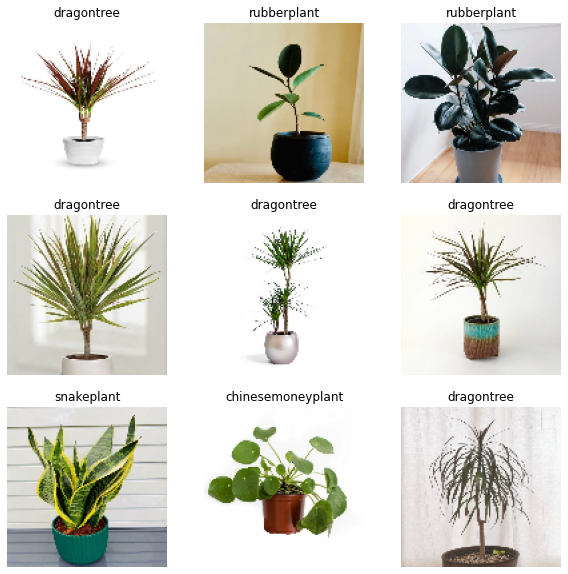

In [ ]:
import matplotlib.pyplot as plt
class_names = ['chinesemoneyplant','dragontree', 'orchid','rubberplant','snakeplant']
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for img, label in test_ds.take(1):
  print("Image shape:", img.shape)

Image shape: (10, 120, 120, 3)


In [ ]:
# Normalise inputs
def normalise(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  return image, label

In [ ]:
train = train_ds.map(normalise)
test = test_ds.map(normalise)
validation = validation_ds.map(normalise)

In [ ]:
batch_size = 32
shuffle_buffer_size = 70

train_batches = train.shuffle(shuffle_buffer_size).batch(batch_size)
validation_batches = validation.batch(batch_size)
test_batches = test.batch(batch_size)